In [1]:
import numpy as np
from scipy.sparse import csr_matrix, find
from scipy.spatial import cKDTree
from tqdm import tqdm_notebook as tqdm

from datasets.graph import draw_sample
import torch

#dataset = 'all_track'
#dataset = 'all_track_lowpt'
#dataset = 'all_track_id'
#dataset = 'all_track_lowpt_id'
#dataset = 'all_track_ec'
#dataset = 'all_track_lowpt_ec'
#dataset = 'all_track_eco'
#dataset = 'all_track_lowpt_eco'
#dataset = 'all_track_dr'
#dataset = 'all_track_lowpt_dr'
#dataset = 'all_track_lowpt_id_inv'
#dataset = 'all_track_lowpt_id_invs'
#dataset = 'all_track_id_aug'
#dataset = 'all_track_lowpt_id_aug'

# dataset = 'barrel_pt2.0'
# dataset = 'barrel_pt2.0_original'
# dataset = 'barrel_pt2.0_tuned'
# dataset = 'barrel_pt2.0_phi'

# dataset = 'endcap_pt2.0'
# dataset = 'endcap_pt2.0_original'
# dataset = 'endcap_pt2.0_tuned'
# dataset = 'endcap_pt2.0_phi'

# dataset = 'detector_pt2.0'
# dataset = 'detector_pt2.0_balanced'
# dataset = 'detector_pt2.0_original'
# dataset = 'detector_pt2.0_tuned'
# dataset = 'detector_pt2.0_phi'
# dataset = 'detector_pt2.0_intersect2'
# dataset = 'detector_pt2.0_phioptimize'
# dataset = 'detector_pt2.0_z0optimize'
# dataset = 'detector_pt2.0_noz0'
dataset = 'detector_pt2.0_nobatch'

# dataset = 'detector_pt0.5'
# dataset = 'detector_pt1.0'
# dataset = 'detector_pt1.5'
# dataset = 'detector_pt2.0'
# dataset = 'detector_pt2.5'
# dataset = 'detector_pt3.0'
# dataset = 'detector_pt3.5'
# dataset = 'detector_pt4.0'
# dataset = 'detector_pt4.5'
# dataset = 'detector_pt5.0'



model_fname = '/data/gnn_code/hgcal_ldrd/output/'+dataset+'/checkpoints/model_checkpoint_EdgeNetWithCategories_259075_140efb4178_markus.best.pth.tar'
plot_prefix = '/data/gnn_code/hgcal_ldrd/plots/'+dataset+'_'

#dataset = 'all_track_id'
test_fname = '/data/gnn_code/training_data/'+dataset+'/test/data_99.pt'

In [2]:
from models.EdgeNetWithCategories import EdgeNetWithCategories

#mdl = EdgeNetWithCategories(input_dim=5, hidden_dim=64, output_dim=4, n_iters=6).to('cuda:0')
mdl = EdgeNetWithCategories(input_dim=3, hidden_dim=64, output_dim=2, n_iters=6).to('cuda:0')

mdl.load_state_dict(torch.load(model_fname)['model'])
mdl.eval()

EdgeNetWithCategories(
  (inputnet): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
  )
  (edgenetwork): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=2, bias=True)
    (5): LogSoftmax()
  )
  (nodenetwork0): EdgeConv(nn=Sequential(
    (0): Linear(in_features=134, out_features=99, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=99, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
  ))
  (nodenetwork1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=134, out_features=99, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=99, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
  

In [3]:
def compare_clusters(cluster1, cluster2):
    if len(cluster1) == len(cluster2):
        for i in range(len(cluster1)):
            if cluster1[i] != cluster2[i]:
                return 0
        return 1
    else:
        return 0


In [4]:
def process_file(fname):
    data = torch.load(fname).to('cuda:0')
    
    with torch.no_grad():
        pred_edges = mdl(data).detach()
        pred_edges_np = pred_edges.cpu().numpy()
        
    #print(np.unique(np.argmax(pred_edges_np,axis=-1), return_counts=True))
    #print(torch.unique(data.y.cpu(), return_counts=True))
    
    X = data.x.cpu().numpy()
    index = data.edge_index.cpu().numpy().T
    y = data.y.cpu().numpy()

    out = np.argmax(pred_edges_np,axis=-1)

        
    from unionfind import unionfind
    finder_gnn = unionfind(X.shape[0])
    finder_tru = unionfind(X.shape[0])

    Hits_minimum = 3

    for i in tqdm(range(index.shape[0])):
        if out[i] == 1:
            finder_gnn.unite(index[i,0], index[i,1])
        if y[i] == 1:
            finder_tru.unite(index[i,0], index[i,1])

    gnn_roots = np.array([finder_gnn.find(i) for i in range(X.shape[0])], dtype=np.uint32)
    tru_roots = np.array([finder_tru.find(i) for i in range(X.shape[0])], dtype=np.uint32)
    
    tru_clusters = np.unique(tru_roots, return_inverse=True, return_counts=True)
    trus = tru_clusters[0][np.where(tru_clusters[2] >= Hits_minimum)]
    tru_clusters_sel = {i: np.where(tru_roots == tru)[0] for i, tru in enumerate(trus)}

    gnn_clusters = np.unique(gnn_roots, return_inverse=True, return_counts=True)
    gnns = gnn_clusters[0][np.where(gnn_clusters[2] >= Hits_minimum)]
    gnn_clusters_sel = {i: np.where(gnn_roots == gnn)[0] for i, gnn in enumerate(gnns)}

    N_true = len(tru_clusters_sel)
    N_gnn = len(gnn_clusters_sel)

    N_matched = 0
    N_fakes   = 0

    for i in range(N_gnn):
        match = 0
        for j in range(N_true):
            if compare_clusters(gnn_clusters_sel[i], tru_clusters_sel[j]):
                match = 1
        if match == 1:
            N_matched = N_matched+1   
        else:
            N_fakes = N_fakes+1


    track_efficiency = N_matched / N_true
    fake_fraction = N_fakes / N_gnn

#     print("Track Efficiency is " + str(track_efficiency))
#     print("Fake Fraction is " + str(fake_fraction))
    
    return track_efficiency, fake_fraction

In [5]:
data = torch.load(test_fname).to('cuda:0')

with torch.no_grad():
    pred_edges = mdl(data).detach()
    pred_edges_np = pred_edges.cpu().numpy()

#print(np.unique(np.argmax(pred_edges_np,axis=-1), return_counts=True))
#print(torch.unique(data.y.cpu(), return_counts=True))

X = data.x.cpu().numpy()
index = data.edge_index.cpu().numpy().T
y = data.y.cpu().numpy()

out = np.argmax(pred_edges_np,axis=-1)

Ro = index[:,0]
Ri = index[:,1]

Ro_truth = Ro[y>0]
Ri_truth = Ri[y>0]
Ro_out = Ro[out>0]
Ri_out = Ri[out>0]

errors = y-out

Ro_fakes = Ro[errors<0]
Ri_fakes = Ri[errors<0]
Ro_missed = Ro[errors>0]
Ri_missed = Ri[errors>0]

n_nodes = X.shape[0]
n_edges = y.size

width1 = .1
width2 = .2
points = .25

# #TrackML Barrel
# if dataset == "all_track" or dataset == "all_track_lowpt":
#     R_max = 1050
#     Z_max = 1200

# #TrackML Barrel: Inner Detector
# elif dataset == "all_track_id" or dataset == "all_track_lowpt_id":
#     R_max = 200
#     Z_max = 600
# elif dataset == "all_track_id_aug" or dataset == "all_track_lowpt_id_aug":
#     R_max = 200
#     Z_max = 600

# #TrackML Barrel: Inner Detector
# elif dataset == "all_track_id_inv" or dataset == "all_track_lowpt_id_inv":
#     R_max = 40000
#     Z_max = 600

# #TrackML Barrel: Inner Detector
# elif dataset == "all_track_id_invs" or dataset == "all_track_lowpt_id_invs":
#     R_max = 35000
#     Z_max = 20000

# #TrackML Barrel/Endcap: Inner Detector
# elif dataset == "all_track_dr" or dataset == "all_track_lowpt_dr" or dataset == "all_track_ec" or dataset == "all_track_lowpt_ec" or dataset == "all_track_eco" or dataset == "all_track_lowpt_eco":
#     R_max = 200
#     Z_max = 1600

# elif dataset == "detector_pt2.0" or dataset == "endcap_pt2.0" or dataset == "barrel_pt2.0":
R_max = 200
Z_max = 1600

#ATLAS Barrel: Inner Detector
#R_max = 300
#Z_max = 400

#ATLAS Barrel
#R_max = 1050
#Z_max = 1500


R_coordinate = np.zeros(n_nodes)
Z_coordinate = np.zeros(n_nodes)
Phi_coordinate = np.zeros(n_nodes)
X_coordinate = np.zeros(n_nodes)
Y_coordinate = np.zeros(n_nodes)

for i in range(n_nodes):
    R_coordinate[i] = 1000*X[i][0]
    Phi_coordinate[i] = np.pi*X[i][1]
    Z_coordinate[i] = 1000*X[i][2]
    X_coordinate[i] = 1000*X[i][0]*np.cos(np.pi*X[i][1])
    Y_coordinate[i] = 1000*X[i][0]*np.sin(np.pi*X[i][1])

In [6]:
def draw_sample(x_coord, x_lab, x_min, x_max, y_coord, y_lab, y_min, y_max):
    import matplotlib.pyplot as plt
    #fig, (ax0,ax1,ax2) = plt.subplots(3, 1, dpi=400, figsize=(10, 30))
    fig, (ax0) = plt.subplots(1, 1, dpi=400, figsize=(5, 5))

    # Adjust axes
    ax0.set_xlabel(x_lab)
    ax0.set_ylabel(y_lab)
    ax0.set_xlim(x_min, x_max)
    ax0.set_ylim(y_min, y_max)
#     ax1.set_xlabel(x_lab)
#     ax1.set_ylabel(y_lab)
#     ax1.set_xlim(x_min, x_max)
#     ax1.set_ylim(y_min, y_max)
#     ax2.set_xlabel(x_lab)
#     ax2.set_ylabel(y_lab)
#     ax2.set_xlim(x_min, x_max)
#     ax2.set_ylim(y_min, y_max)

    #plot points
    ax0.scatter(x_coord, y_coord, s=points, c='k')
#     ax1.scatter(x_coord, y_coord, s=points, c='k')
#     ax2.scatter(x_coord, y_coord, s=points, c='k')

    #Draw Edges
#     ax0.plot([x_coord[Ro.astype(int)], x_coord[Ri.astype(int)]],
#              [y_coord[Ro.astype(int)], y_coord[Ri.astype(int)]],
#              '-', c='blue', linewidth=width1)
#     ax0.plot([x_coord[Ro_truth.astype(int)], x_coord[Ri_truth.astype(int)]],
#              [y_coord[Ro_truth.astype(int)], y_coord[Ri_truth.astype(int)]],
#              '-', c='black', linewidth=width2)

#     ax1.plot([x_coord[Ro.astype(int)], x_coord[Ri.astype(int)]],
#              [y_coord[Ro.astype(int)], y_coord[Ri.astype(int)]],
#              '-', c='blue', linewidth=width1) 
#     ax1.plot([x_coord[Ro_out.astype(int)], x_coord[Ri_out.astype(int)]],
#              [y_coord[Ro_out.astype(int)], y_coord[Ri_out.astype(int)]],
#              '-', c='black', linewidth=width2)
    
#     ax2.plot([x_coord[Ro_missed.astype(int)], x_coord[Ri_missed.astype(int)]],
#              [y_coord[Ro_missed.astype(int)], y_coord[Ri_missed.astype(int)]],
#              '-', c='red', linewidth=width2)
#     ax2.plot([x_coord[Ro_fakes.astype(int)], x_coord[Ri_fakes.astype(int)]],
#              [y_coord[Ro_fakes.astype(int)], y_coord[Ri_fakes.astype(int)]],
#              '-', c='green', linewidth=width2)

    ax0.plot([x_coord[Ro_missed.astype(int)], x_coord[Ri_missed.astype(int)]],
             [y_coord[Ro_missed.astype(int)], y_coord[Ri_missed.astype(int)]],
             '-', c='red', linewidth=width2)
    ax0.plot([x_coord[Ro_fakes.astype(int)], x_coord[Ri_fakes.astype(int)]],
             [y_coord[Ro_fakes.astype(int)], y_coord[Ri_fakes.astype(int)]],
             '-', c='green', linewidth=width2)
    
    if (x_lab == 'Z[mm]' and y_lab == 'R[mm]'):
        ax0.plot([-490.975, 490.975], [71.56298065185547, 71.56298065185547],
                 '-', c='blue', linewidth=width2)    
        ax0.plot([-490.975, 490.975], [115.37811279296875, 115.37811279296875],
                 '-', c='blue', linewidth=width2)
        
    fig.savefig(plot_prefix + x_lab + '_' + y_lab + '_error.png')

In [7]:
N_events = 100
efficiency = 0
fake = 0

for i in range(N_events):
    fname = '/data/gnn_code/training_data/'+dataset+'/processed/data_'+str(i)+'.pt'
#     print(fname)
    file_results = process_file(fname)
    
    if i == 0:
        efficiency = file_results[0]
        fake       = file_results[1]
        
    else:
        efficiency = np.append(efficiency, file_results[0])
        fake       = np.append(fake,       file_results[1])
#     print("Track Efficiency = " + str(efficiency/(i+1)))
#     print("Fake Fraction = " + str(fake/(i+1)))

average_efficiency  = efficiency.mean()
variance_efficiency = efficiency.std()
average_fake  = fake.mean()
variance_fake = fake.std()

print("Average Track Efficiency is " + str(average_efficiency) + " +/- " + str(variance_efficiency))
print("Average Fake Fraction is " + str(average_fake) + " +/- " + str(variance_fake))

file = open(plot_prefix + 'efficiency.txt', 'w')
file.write('Average Track Efficiency is ' + str(average_efficiency) + " +/- " + str(variance_efficiency) + '\n')
file.write('Average Fake Fraction is ' + str(average_fake) + " +/- " + str(variance_fake) + '\n')
file.close()

/home/atkinsn2/anaconda3/envs/hgcal-env/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Average Track Efficiency is 0.99469633450831 +/- 0.007420464322992126
Average Fake Fraction is 0.004020799681516493 +/- 0.005934675518634379


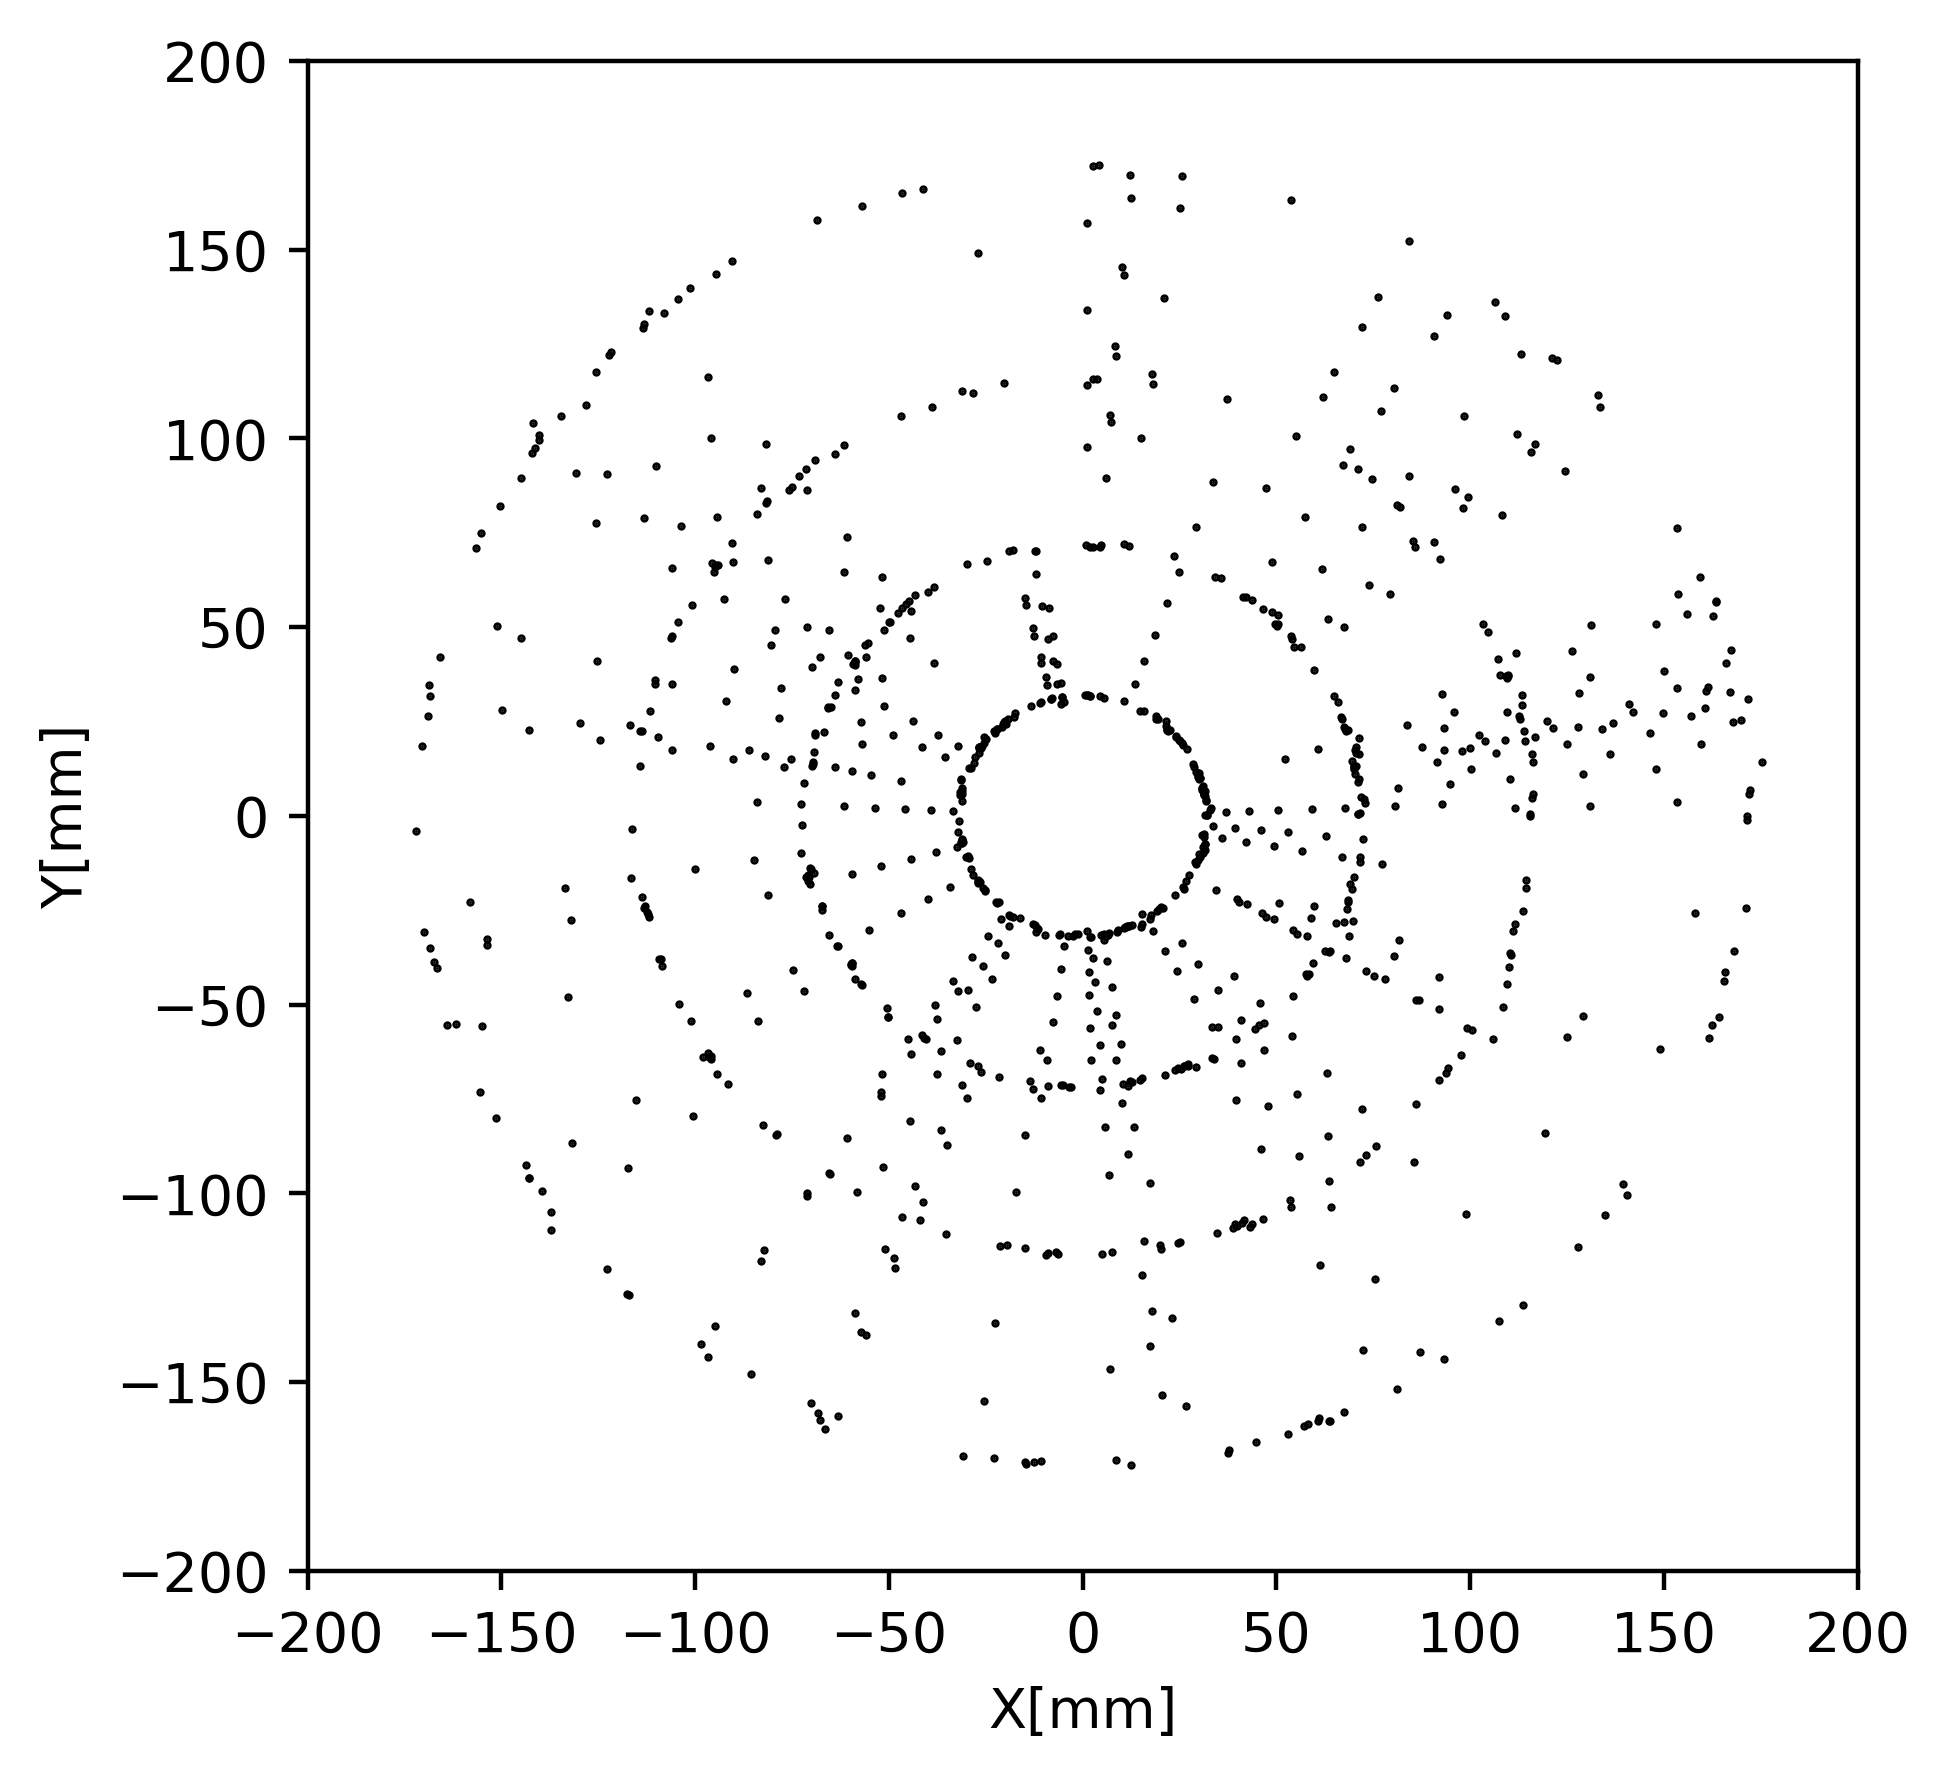

In [8]:
draw_sample(X_coordinate, 'X[mm]', -R_max, R_max, 
            Y_coordinate, 'Y[mm]', -R_max, R_max)

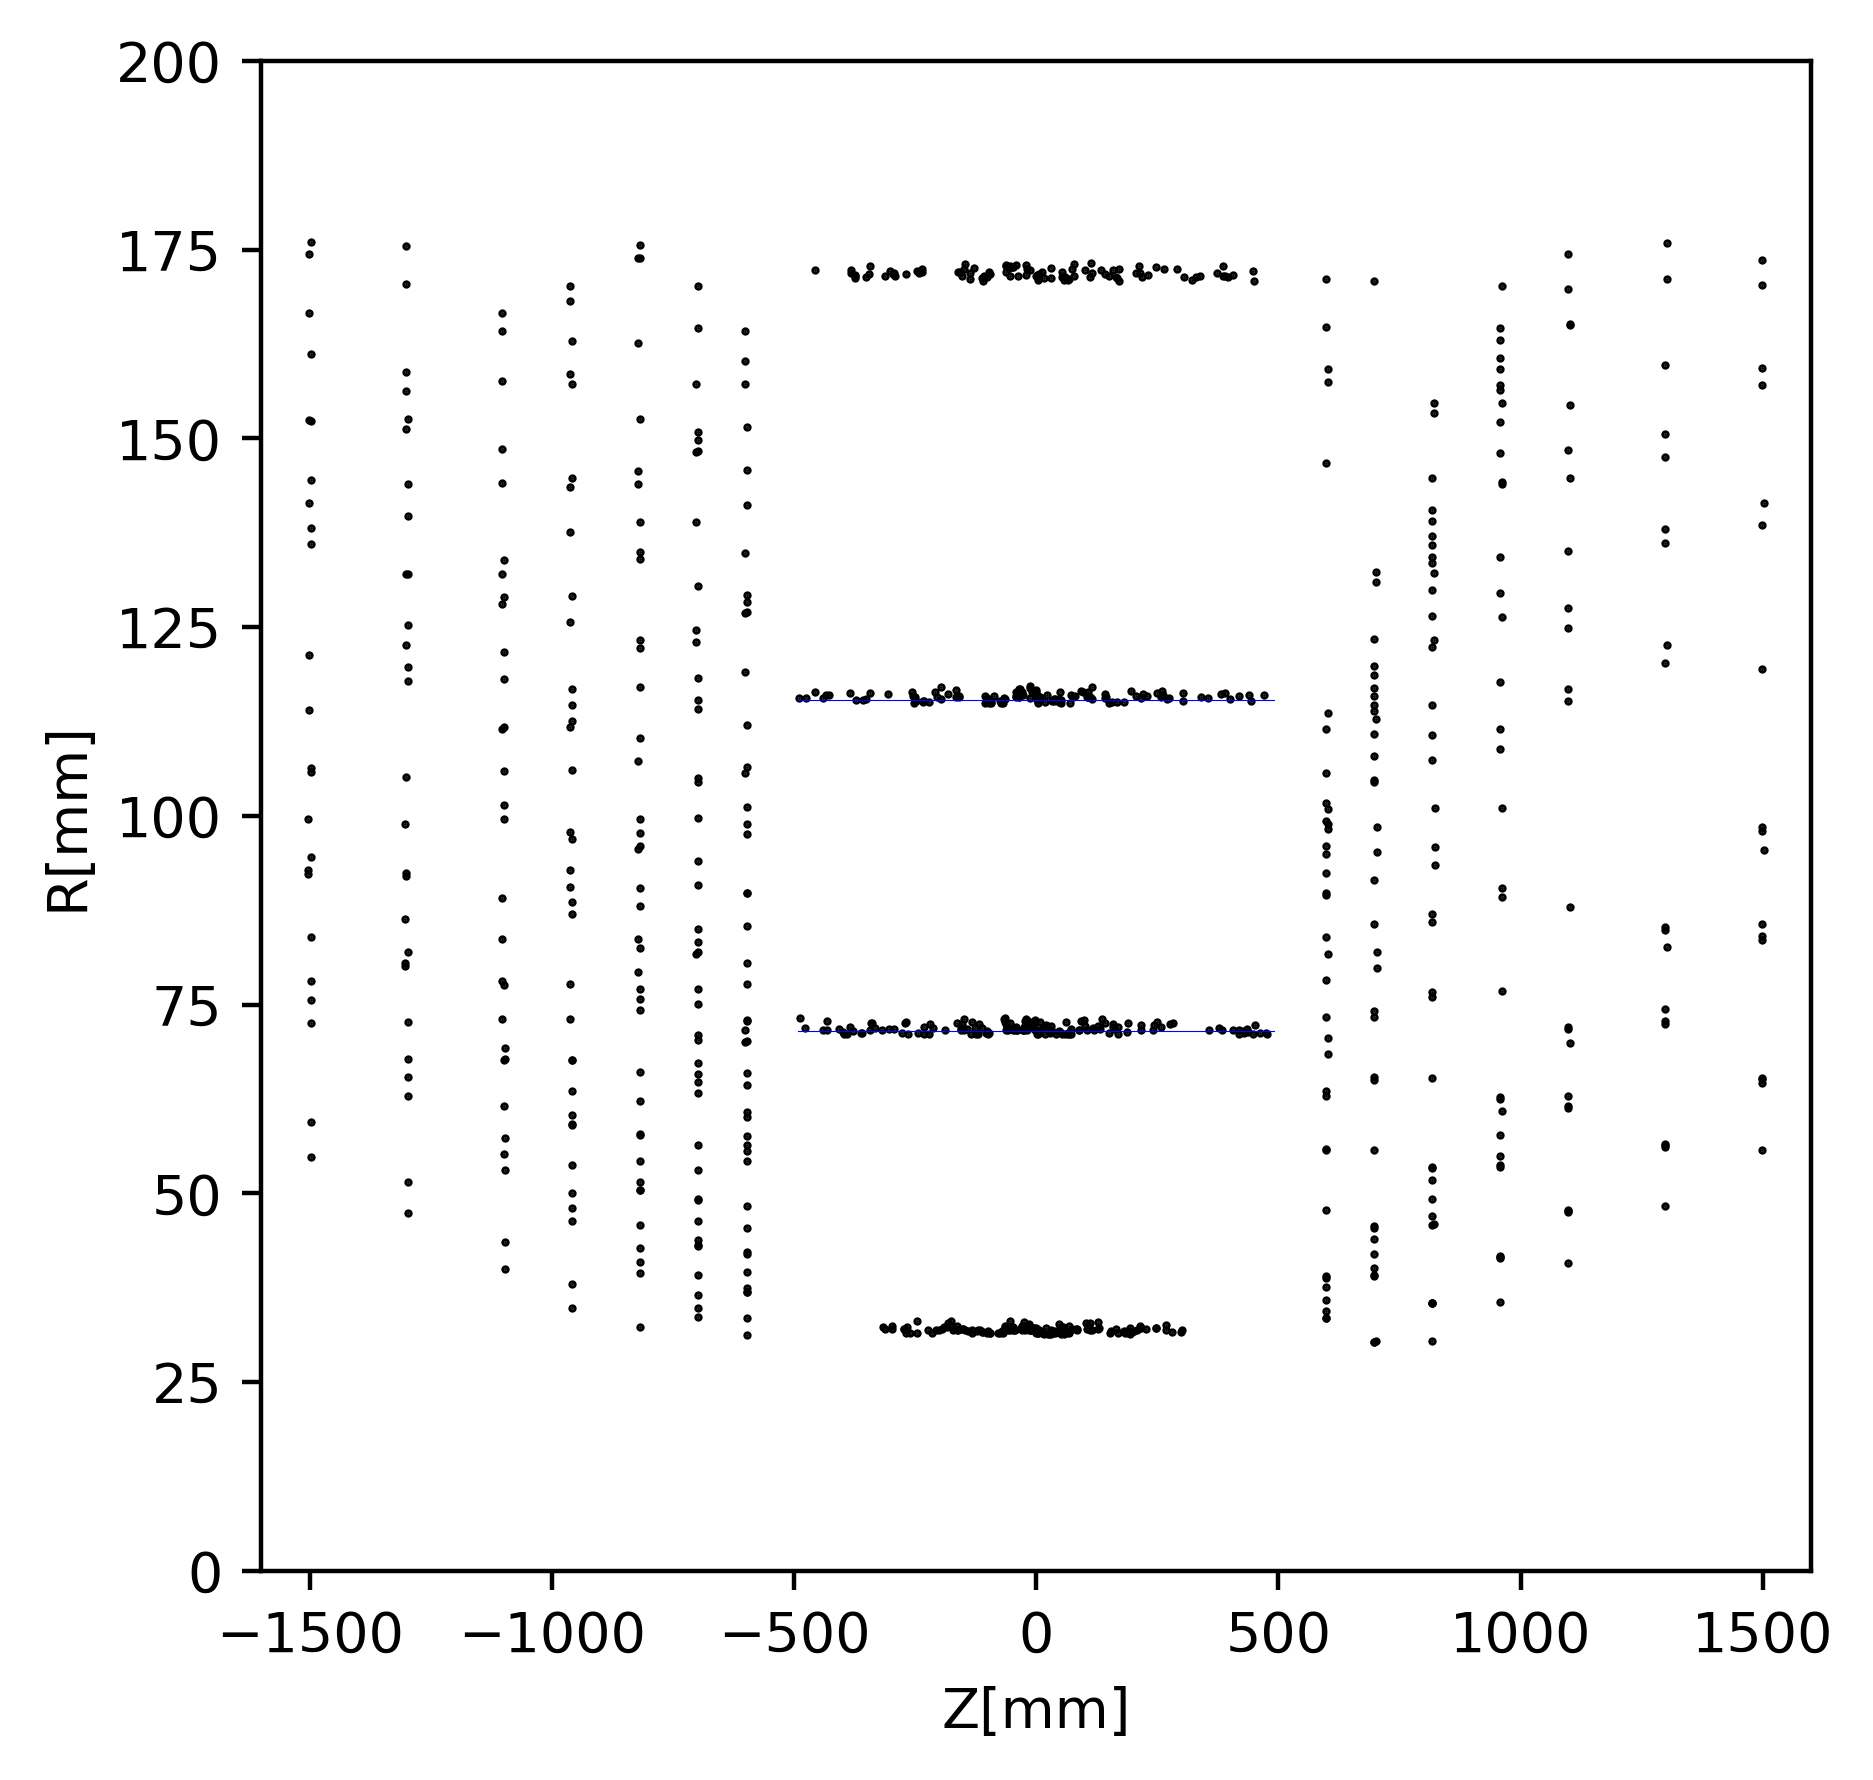

In [9]:
draw_sample(Z_coordinate, 'Z[mm]', -Z_max, Z_max, 
            R_coordinate, 'R[mm]', 0, R_max)